In [1]:
## Standard Imports ##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import numpy as np
import scipy as sp

import sys,os

## Import Handmade Functions ##
sys.path.append(os.path.join(os.path.abspath(''), '00-GeneralFunctions'))
import inp

# Generate Input Excitation
The purpose of this file is to generate and save the input excitation, true state of the system, measurement data, and uncertainty information so that it can be used uniformly across each sample case. 

The excitation used to train the model for this example is a Band-limited white noise (BLWN) excitation, ranging from 0-10 Hz, with a maximum amplitude of 15 m/sec$^2$. This sample excitation is then used as the control input to simulate the response of the SDOF oscillator with a nonlinear Bouc-Wen switch state. An additional BLWN excitation is used to generate a system response to assess the predictive capacity of the inferred SDOF model. This "secondary event" has a 0-20 Hz frequency range and a maximum amplitude of 10 m/sec$^2$. 

## System Parameters

In [2]:
## Experimental Conditions ##
fs = 256.  # sampling frquency [Hz]
dt = 1/fs  # time step [sec]

## True Parameters ##
m = 1.    # mass [kg]
c = 0.3   # damping coefficient [Ns/m]
k = 9.    # stiffness [N/m]
beta = 2  # Bouc-Wen shape parameter [1/m^2]
gamma = 1 # Bouc-Wen shape parameter [1/m^2]
n = 2     # Bouc-Wen shape parameter [--]
alpha = np.array([0,1]) # switch condition [--]

xi = c/2/np.sqrt(k*m)   # damping ratio [--]
wn = np.sqrt(k/m)       # natural frequency [--]

## Initial Conditions ##
ics = [0., 0., 0.]          # system assumed at rest [disp, vel, Bouc-Wen disp] = 0
par = [xi,wn,beta,gamma,n]

## Noise Factors ##
seeds = [234,1234,2345]
wNoise = np.ones(3)*0.02    # 2% RMS process error 
vNoise = 0.2                # 20% RMS observation error

## Primary BLWN Signal (Used to Train SDOF Model)

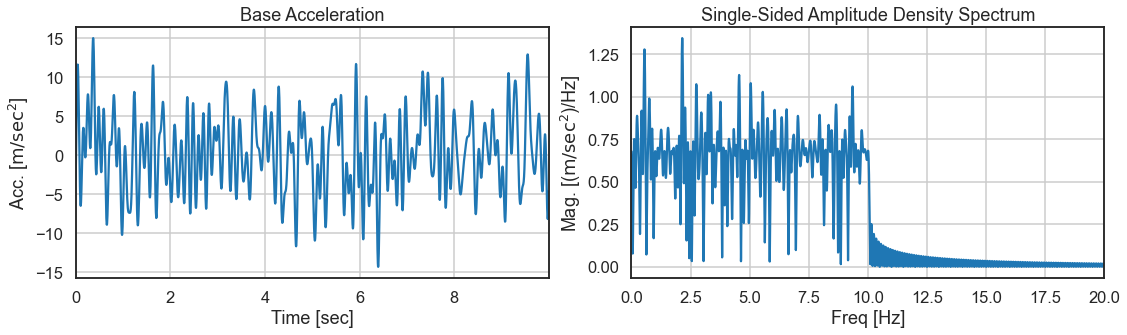

In [3]:
np.random.seed(seeds[0])

## Input Signal Characteristics ##
Tmax = 10.  # signal duration [sec]
Fmax = 10   # cutoff frequency [Hz]
amp = 15.0  # maximum amplitude [m/sec^2]

## Generate Signal ##
(time, inpDisp, inpAcc) = inp.BLWN(Tmax, Fmax, amp, fs, plot=True, fSize=(16,5))

plt.savefig('03-Figures/01-InferenceInput.tiff', dpi=600)

## System Response

In [4]:
def BW(y, par, alpha, exc=None):
    """
    This is the state space model for a nondimensionalized SDOF System with a Bouc-Wen switch component.
      
    y = 1x3 vector of states 
    par = 1x6 vector of params (xi,wn,beta,gamma,n)
    alpha = Bouc-Wen contribution factor (0 = linear system, 1 = full Bouc-Wen system)
    exc = base excitation vector
    """
    if exc is None:
        exc = np.zeros(y[0].shape)
            
    x1dot = y[1]
    x2dot = -exc - 2*par[0]*par[1]*y[1] - (1-alpha)*np.square(par[1])*y[0] - alpha*np.square(par[1])*y[2] 
    x3dot = (y[1] - par[2]*np.absolute(y[1])*np.power(np.absolute(y[2]), par[4]-1)*y[2] 
        - par[3]*y[1]*np.power(np.absolute(y[2]), par[4]))

    return np.stack((x1dot, x2dot, x3dot), axis=0)

def smoothBW(y, par, alpha, exc=None):
    """
    This is the state space model for a nondimensionalized SDOF System with a Bouc-Wen switch component.
    The absolute values and sign functions in this model have been smoothed to make the extended Kalman
    filter analytically tractable. Though this model is not used to generate inference input, it is 
    used to verify that the smoothed model can replicate the true response fairly well. 
      
    y = 1x3 vector of states 
    par = 1x6 vector of params (xi,wn,beta,gamma,n)
    alpha = Bouc-Wen contribution factor (0 = linear system, 1 = full Bouc-Wen system)
    exc = base excitation vector
    """
    rho = 20            # Smoothing constant for tamh() approximation to sign() function.
                        # Selected to give sufficient point density at the transition
                        # for the sampling frequency of the inference problem. 
    
    if exc is None:
        exc = np.zeros(y[0].shape)
        
    x1dot = y[1]
    x2dot = -exc - 2*par[0]*par[1]*y[1] - (1-alpha)*np.square(par[1])*y[0] - alpha*np.square(par[1])*y[2] 
    x3dot = (y[1] - par[2]*y[1]*np.power(np.tanh(rho*y[2])*y[2], par[4])*np.tanh(rho*y[1]*y[2]) 
        - par[3]*y[1]*np.power(np.tanh(rho*y[2])*y[2], par[4]))

    return np.stack((x1dot, x2dot, x3dot), axis=0)

def Euler(fun, dt, y, par, alpha, inp):
    """
    Euler integration scheme. 
     
    fun = dynamical system model, defined as a function
    y = 1x3 vector of states 
    par = 1x6 vector of params (xi,wn,beta,gamma,n)
    alpha = Bouc-Wen contribution factor (0 = linear system, 1 = full Bouc-Wen system)
    exc = base excitation vector
    """
    return y + dt*fun(y,par,alpha,exc=inp)

### Build Linear Response

In [5]:
### Build Ideal Model Response ###
statesLinear = np.zeros((len(ics),len(time)))
statesLinear[:,0] = ics

for tt in range(1,len(time)):
    statesLinear[:,tt] = Euler(BW, dt, statesLinear[:,tt-1], 
                               par, alpha[0], inpAcc[tt-1])

accLinear = BW(statesLinear, par, alpha[0])[1]

### Build True System Response ###
# Build Process Noise Vector #
np.random.seed(seeds[1])
rmsStates = np.sqrt(np.mean(np.square(statesLinear), axis=1))
stdW_Linear = np.sqrt(dt)*rmsStates*wNoise  # standard deviation of the process noise (element-wise)
wLinear = stdW_Linear.reshape(-1,1)*np.random.multivariate_normal(np.zeros(len(ics)), 
                                        np.eye(len(ics)), len(time)).transpose()

# Build Measurement Noise Vector #
np.random.seed(seeds[2])
rmsMeas = np.sqrt(np.mean(np.square(accLinear)))
stdV_Linear = rmsMeas*vNoise                      # standard deviation of the measurement noise
vLinear = stdV_Linear*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate True System Response (Includes Process Noise) #
statesLinearPNoise = np.zeros((len(ics),len(time)))
statesLinearPNoise[:,0] = ics

for tt in range(1,len(time)):
    statesLinearPNoise[:,tt] = Euler(BW, dt, statesLinearPNoise[:,tt-1],
                                     par, alpha[0], inpAcc[tt-1]) + wLinear[:,tt-1]

accLinearPMNoise = BW(statesLinearPNoise, par, alpha[0])[1] + vLinear

### Build Bouc-Wen Response

In [6]:
### Build Ideal Model Response ###
statesBW = np.zeros((len(ics),len(time)))
statesBW[:,0] = ics

for tt in range(1,len(time)):
    statesBW[:,tt] = Euler(BW, dt, statesBW[:,tt-1], par, alpha[1], inpAcc[tt-1])

accBW = BW(statesBW, par, alpha[1])[1]

### Build Ideal Model Response - Smoothed System Approximation ###
statesSmoothBW = np.zeros((len(ics),len(time)))
statesSmoothBW[:,0] = ics

for tt in range(1,len(time)):
    statesSmoothBW[:,tt] = Euler(smoothBW, dt, statesSmoothBW[:,tt-1], 
                                par, alpha[1], inpAcc[tt-1])

accSmoothBW = smoothBW(statesSmoothBW, par, alpha[1])[1]

### Build True System Response ###
# Build Process Noise Vector #
np.random.seed(seeds[1])
rmsStates = np.sqrt(np.mean(np.square(statesBW), axis=1))
stdW_BW = np.sqrt(dt)*rmsStates*wNoise  # standard deviation of the process noise (element-wise)
wBW = stdW_BW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(len(ics)), 
                                        np.eye(len(ics)), len(time)).transpose()

# Build Measurement Noise Vector #
np.random.seed(seeds[2])
rmsMeas = np.sqrt(np.mean(np.square(accBW)))
stdV_BW = rmsMeas*vNoise                      # standard deviation of the measurement noise
vBW = stdV_BW*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate True System Response (Includes Process Noise) #
statesPNoiseBW = np.zeros((len(ics),len(time)))
statesPNoiseBW[:,0] = ics

for tt in range(1,len(time)):
    statesPNoiseBW[:,tt] = Euler(BW, dt, statesPNoiseBW[:,tt-1], 
                               par, alpha[1], inpAcc[tt-1]) + wBW[:,tt-1]

accPMNoiseBW = BW(statesPNoiseBW, par, alpha[1])[1] + vBW

### Confirm Smoothed Model is a Good Approximation

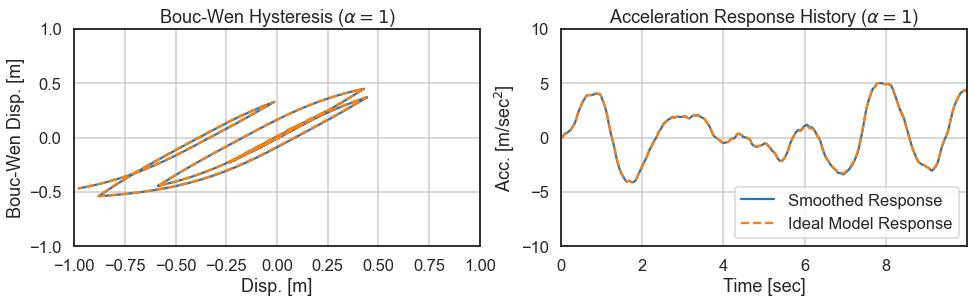

In [7]:
## Plot the Smoothed Bouc-Wen Model Response
fig, ax = plt.subplots(1,2, figsize = (16, 4))
ax[0].plot(statesSmoothBW[0,:],statesSmoothBW[2,:],  color = 'C0', label="Smoothed Response")
ax[0].plot(statesBW[0,:],statesBW[2,:], '--', color = 'C1', label="Ideal Model Response")
ax[0].set_xlabel('Disp. [m]')
ax[0].set_ylabel('Bouc-Wen Disp. [m]')
ax[0].set_title(r'Bouc-Wen Hysteresis ($\alpha=1$)')
ax[0].set_xlim((-1, 1))
ax[0].set_ylim((-1, 1))
ax[0].grid(1)

ax[1].plot(time,accSmoothBW, label="Smoothed Response")
ax[1].plot(time,accPMNoiseBW - vBW, '--', label="Ideal Model Response")
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel(r'Acc. [m/sec$^2$]')
ax[1].set_title(r'Acceleration Response History ($\alpha=1$)')
ax[1].set_xlim((0, time[-1]))
ax[1].set_ylim((-10, 10))
ax[1].grid(1)
ax[1].legend(loc ='lower right')

### Plot System Response

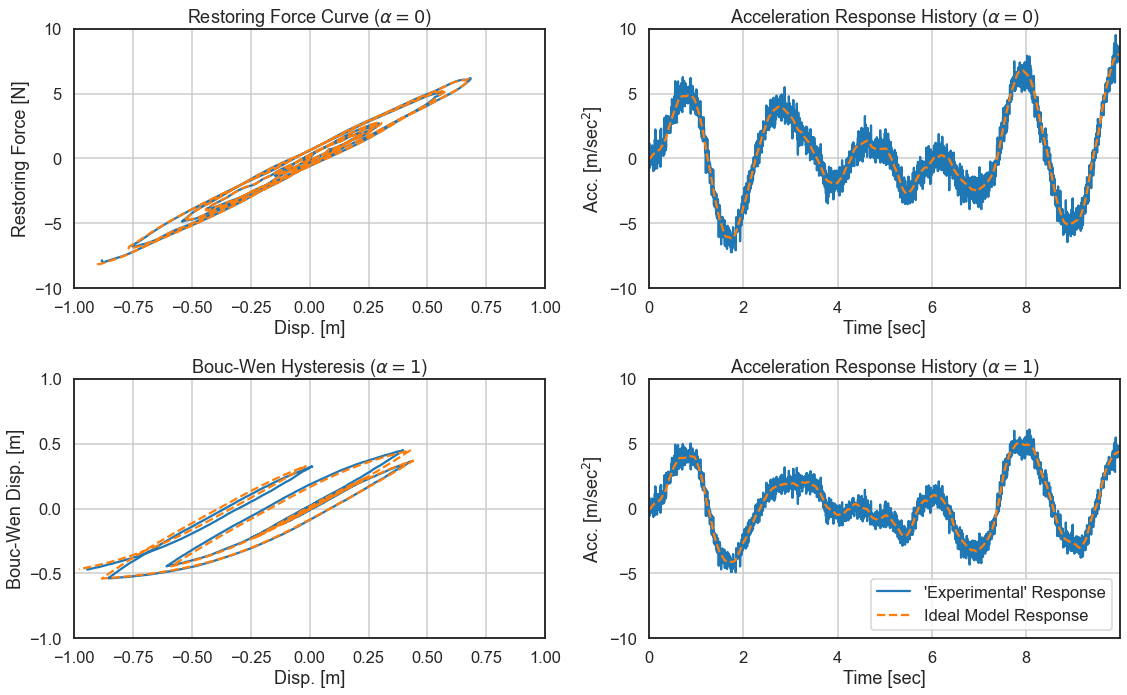

In [8]:
### Figure for the Paper ###
fig, ax = plt.subplots(2,2, figsize = (16, 10))
ax[0,0].plot(statesLinearPNoise[0,:],-m*(accLinearPMNoise - vLinear), color = 'C0', label="'Experimental' Response")
ax[0,0].plot(statesLinear[0,:],-m*(accLinear),  '--',color = 'C1', label="Ideal Model Response")
ax[0,0].set_xlabel('Disp. [m]')
ax[0,0].set_ylabel('Restoring Force [N]')
ax[0,0].set_title(r'Restoring Force Curve ($\alpha=0$)')
ax[0,0].set_xlim((-1, 1))
ax[0,0].set_ylim((-10, 10))
ax[0,0].grid(1)
#ax[1,0].legend(loc ='lower right')

ax[0,1].plot(time,accLinearPMNoise,  label="'Experimental' Response")
ax[0,1].plot(time,(accLinearPMNoise - vLinear), '--', label="Ideal Model Response")
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_ylabel(r'Acc. [m/sec$^2$]')
ax[0,1].set_title(r'Acceleration Response History ($\alpha=0$)')
ax[0,1].set_xlim((0, time[-1]))
ax[0,1].set_ylim((-10, 10))
ax[0,1].grid(1)
#ax[0,1].legend(loc ='lower right')

ax[1,0].plot(statesPNoiseBW[0,:],statesPNoiseBW[2,:],  color = 'C0', label="'Experimental' Response")
ax[1,0].plot(statesBW[0,:],statesBW[2,:], '--', color = 'C1', label="Ideal Model Response")
ax[1,0].set_xlabel('Disp. [m]')
ax[1,0].set_ylabel('Bouc-Wen Disp. [m]')
ax[1,0].set_title(r'Bouc-Wen Hysteresis ($\alpha=1$)')
ax[1,0].set_xlim((-1, 1))
ax[1,0].set_ylim((-1, 1))
ax[1,0].grid(1)
#ax[0,0].legend(loc ='lower right')

ax[1,1].plot(time,accPMNoiseBW, label="'Experimental' Response")
ax[1,1].plot(time,accPMNoiseBW - vBW, '--', label="Ideal Model Response")
ax[1,1].set_xlabel('Time [sec]')
ax[1,1].set_ylabel(r'Acc. [m/sec$^2$]')
ax[1,1].set_title(r'Acceleration Response History ($\alpha=1$)')
ax[1,1].set_xlim((0, time[-1]))
ax[1,1].set_ylim((-10, 10))
ax[1,1].grid(1)
ax[1,1].legend(loc ='lower right')

plt.tight_layout()
plt.savefig('03-Figures/02-InferenceResponse.tiff', dpi=600)

### Save System Input and True Responses

In [9]:
np.savez('01-Linear/inferenceInput', dt = dt, time=time, inpAcc = inpAcc, statesPNoise=statesLinearPNoise, 
         accPMNoise=accLinearPMNoise,Qfactor=stdW_Linear, Rfactor=stdV_Linear, m = m, par=par, ics=ics)

np.savez('02-Bouc-Wen/inferenceInput', dt = dt, time=time, inpAcc = inpAcc, statesPNoise=statesPNoiseBW, 
         accPMNoise=accPMNoiseBW,Qfactor=stdW_BW, Rfactor=stdV_BW, m = m, par=par, ics=ics)

## Secondary BLWN Input Signal (Used to Assess Predictive Capacity)

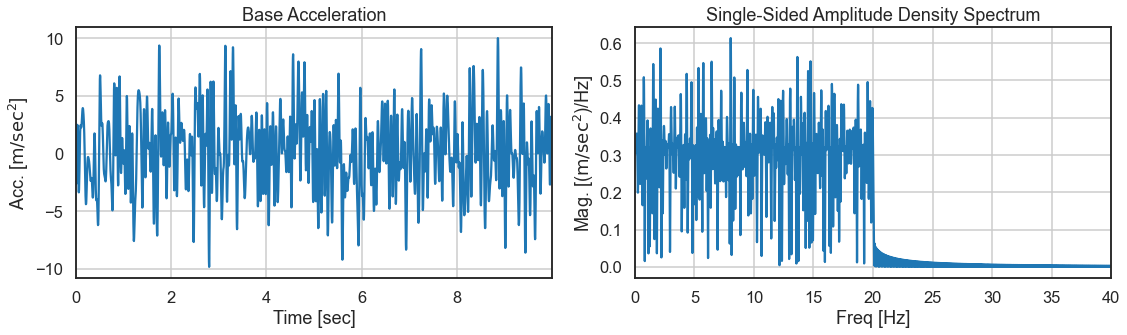

In [10]:
seeds2 = [2165,4432,6654]
np.random.seed(seeds2[0])

## Input Signal Characteristics ##
Tmax = 10.       # signal duration [sec]
Fmax_pred = 20.  # cutoff frequency [Hz]
amp_pred = 10.   # maximum amplitude [m/sec^2]

## Generate Signal ##
(time, predDisp, predBase) = inp.BLWN(Tmax, Fmax_pred, amp_pred, 
                                      fs, plot=True, fSize=(16,5))

plt.savefig('03-Figures/03-PredictiveInput.tiff', dpi=600)

## System Response
### Build Linear Response 

In [14]:
### Initial Conditions ###
icsPredLin = statesLinearPNoise[:,-1] # Extract initial conditions from last step 
                                      # of primary signal response

# Build Process Noise Vector #
np.random.seed(seeds2[1])
wPredLinear = stdW_Linear.reshape(-1,1)*np.random.multivariate_normal(np.zeros(len(icsPredLin)),
                                                    np.eye(len(icsPredLin)), len(time)).transpose()

# Build Measurement Noise Vector #
np.random.seed(seeds2[2])
vPredLinear = stdV_Linear*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate True System Response (Includes Process Noise) #
predStatesPNoiseLinear = np.zeros((len(icsPredLin),len(time)))
predStatesPNoiseLinear[:,0] = icsPredLin

for tt in range(1,len(time)):
    predStatesPNoiseLinear[:,tt] = Euler(BW, dt, predStatesPNoiseLinear[:,tt-1], 
                                         par, alpha[0], predBase[tt-1]) + wPredLinear[:,tt-1]

predAccPMNoiseLinear = BW(predStatesPNoiseLinear, par, alpha[0])[1] + vPredLinear

### Build Bouc-Wen Response

In [15]:
### Initial Conditions ###
icsPredBW = statesPNoiseBW[:,-1] # Extract initial conditions from last step 
                                      # of primary signal response

# Build Process Noise Vector #
np.random.seed(seeds2[1])
wPredBW = stdW_BW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(len(icsPredBW)), 
                                        np.eye(len(icsPredBW)), len(time)).transpose()

# Build Measurement Noise Vector #
np.random.seed(seeds[2])
vPredBW = stdV_BW*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate True System Response (Includes Process Noise) #
predStatesPNoiseBW = np.zeros((len(icsPredBW),len(time)))
predStatesPNoiseBW[:,0] = icsPredBW

for tt in range(1,len(time)):
    predStatesPNoiseBW[:,tt] = Euler(BW, dt, predStatesPNoiseBW[:,tt-1], 
                                     par, alpha[1], predBase[tt-1]) + wPredBW[:,tt-1]

predAccPMNoiseBW = BW(predStatesPNoiseBW, par, alpha[1])[1] + vPredBW

### Plot System Response

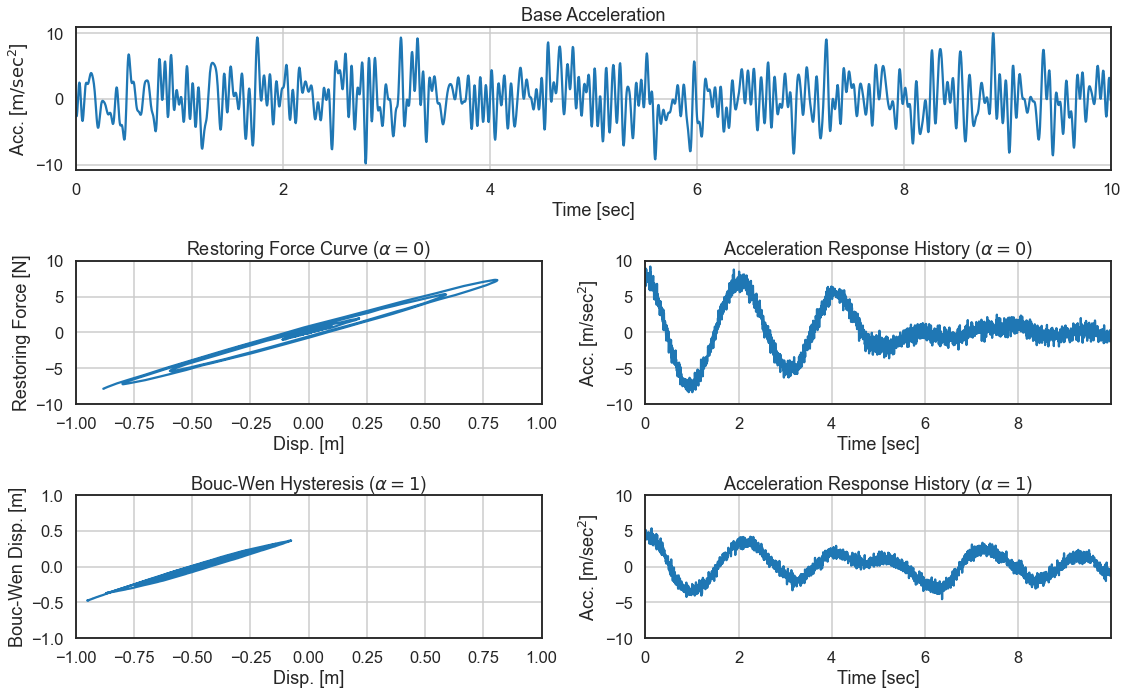

In [16]:
fig = plt.figure(figsize = (16, 10))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(time, predBase)
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel(r'Acc. [$\mathrm{m/sec}^2$]')
ax1.set_title('Base Acceleration')
ax1.set_xlim((0, Tmax))
ax1.grid()

ax2 = fig.add_subplot(3,2,5)
ax2.plot(predStatesPNoiseBW[0,:],predStatesPNoiseBW[2,:],  color = 'C0', label="'Experimental' Response")
ax2.set_xlabel('Disp. [m]')
ax2.set_ylabel('Bouc-Wen Disp. [m]')
ax2.set_title(r'Bouc-Wen Hysteresis ($\alpha=1$)')
ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1))
ax2.grid(1)
#ax2.legend(loc ='lower right')

ax3 = fig.add_subplot(3,2,6)
ax3.plot(time,predAccPMNoiseBW, label="'Experimental' Response")
#ax3.plot(time,predAccPMNoiseBW - vPredBW, '--', label="Ideal Model Response")
ax3.set_xlabel('Time [sec]')
ax3.set_ylabel(r'Acc. [m/sec$^2$]')
ax3.set_title(r'Acceleration Response History ($\alpha=1$)')
ax3.set_xlim((0, time[-1]))
ax3.set_ylim((-10, 10))
ax3.grid(1)
#ax3.legend(loc ='lower right')

ax4 = fig.add_subplot(3,2,3)
ax4.plot(predStatesPNoiseLinear[0,:],-m*(predAccPMNoiseLinear - vPredLinear), color = 'C0', label="'Experimental' Response")
ax4.set_xlabel('Disp. [m]')
ax4.set_ylabel('Restoring Force [N]')
ax4.set_title(r'Restoring Force Curve ($\alpha=0$)')
ax4.set_xlim((-1, 1))
ax4.set_ylim((-10, 10))
ax4.grid(1)
#ax4.legend(loc ='lower right')

ax5 = fig.add_subplot(3,2,4)
ax5.plot(time,predAccPMNoiseLinear,  label="'Experimental' Response")
#ax5.plot(time,(predAccPMNoiseLinear - vPredLinear), '--', label="Ideal Model Response")
ax5.set_xlabel('Time [sec]')
ax5.set_ylabel(r'Acc. [m/sec$^2$]')
ax5.set_title(r'Acceleration Response History ($\alpha=0$)')
ax5.set_xlim((0, time[-1]))
ax5.set_ylim((-10, 10))
ax5.grid(1)
#ax5.legend(loc ='lower right')

plt.tight_layout()
plt.savefig('03-Figures/04-PredictiveResponse.tiff', dpi=600)

### Save Predictive Input and True System Responses

In [17]:
np.savez('01-Linear/predInp_BLWN', dt = dt, time=time, predInp = predBase, predStatesPNoise=predStatesPNoiseLinear, 
         predAccPMNoise=predAccPMNoiseLinear,Qfactor=stdW_Linear, Rfactor=stdV_Linear, m = m, par=par, ics=icsPredLin)

np.savez('02-Bouc-Wen/predInp_BLWN', dt = dt, time=time, predInp = predBase, predStatesPNoise=predStatesPNoiseBW, 
         predAccPMNoise=predAccPMNoiseBW,Qfactor=stdW_BW, Rfactor=stdV_BW, m = m, par=par, ics=icsPredBW)